# CSC 510 Assignment 3
## This Jupyter Notebook file is about building an understanding to select and create a suitable big data system to process big data and perform machine learning algorithms. The following code utilizes an Apache Spark cluster (version 2.4.0).

## Local Big Data System

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, functions
from pyspark.ml.feature import StringIndexer
conf = SparkConf().setAppName("CSC 510 Assignment 3").setMaster("spark://127.0.0.1:7077")
sc = SparkContext.getOrCreate(conf)
sqlContext = SQLContext(sc)

In [3]:
sc

<SparkContext master=spark://127.0.0.1:7077 appName=CSC 510 Assignment 3>

## Machine Learning on Big Data System

**These methods are utilized for processing data prior to Decision Tree Classification.**

In [4]:
def str_idx_col(df, col):
    new_col = col + '_index'
    indexer = StringIndexer(inputCol=col, outputCol=new_col)
    indexed = indexer.fit(df).transform(df).drop(col).withColumnRenamed(new_col, col)
    return indexed

In [5]:
def df_drop_cols(df, df_cols, shared_cols):
    for col in df_cols:
        if col not in shared_cols:
            df = df.drop(col)
            
    return df

In [6]:
def traffic_label(frame, frame_label):
    temp_frame = frame.withColumn("label", functions.when(frame[frame_label] == 0, 0)
                                  .otherwise(1))
    return temp_frame

**Read in the nslkdd-version1.csv and nslkdd-version2.csv files and print out the number of observations in each set.**

In [7]:
v1 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version1.csv",
                         inferSchema="true", header=True).dropna()
v2 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version2.csv",
                         inferSchema="true", header=True).dropna()

print("Number of observations in nslkdd-version1.csv:", v1.count())
print("Number of observations in nslkdd-version2.csv:", v2.count())

Number of observations in nslkdd-version1.csv: 25192
Number of observations in nslkdd-version2.csv: 25192


**Print out the column names in each set, along with the number of columns per dataset, and the common columns in each set.**

In [8]:
v1_cols = v1.columns
v2_cols = v2.columns
comm_cols = sorted(set(v1_cols).intersection(v2_cols))
print("Columns of nslkdd-version1.csv:\n", v1_cols, "\n\t(# of columns = %d)" % len(v1_cols))
print("\n\nColumns of nslkdd-version2.csv:\n", v2_cols, "\n\t(# of columns = %d)" % len(v2_cols))
print("\n\nCommon columns of nslkdd-version1.csv and nslkdd-version2.csv:\n", comm_cols,
      "\n\t(# of columns = %d)" % len(comm_cols))

Columns of nslkdd-version1.csv:
 ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'a40', 'a41', 'a42'] 
	(# of columns = 42)


Columns of nslkdd-version2.csv:
 ['a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'a40', 'a41', 'a42'] 
	(# of columns = 36)


Common columns of nslkdd-version1.csv and nslkdd-version2.csv:
 ['a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'a40', 'a41', 'a42', 'a7', 'a8', 'a9'] 
	(# of columns = 36)


**Convert nslkdd-version1.csv label column from categorical values to numerical values, then determine whether the row is classified an attack-traffic type or a normal-traffic type for both datasets.**

In [9]:
v1 = str_idx_col(v1, 'a42')
v1 = traffic_label(v1, "a42")
v2 = traffic_label(v2, "a42")

**Remove the original label column and keep the newly created label column.**

In [10]:
comm_cols.remove("a42")
comm_cols.append("label")
v1 = df_drop_cols(v1, v1_cols, comm_cols)
v2 = df_drop_cols(v2, v2_cols, comm_cols)

**Using only the columns that each dataset has, compare each feature in a dataset to its counterpart set-feature. Drop them if they do not have similar statistical values; otherwise, keep them.**

In [11]:
comm_sum = []

for col in comm_cols:
    v1_sum = [val for val in v1.select(col).summary().select(col).collect()]
    v2_sum = [val for val in v2.select(col).summary().select(col).collect()]
    
    if v1_sum == v2_sum:
        comm_sum.append(col)

In [12]:
v1 = df_drop_cols(v1, v1.columns, comm_sum)
v2 = df_drop_cols(v2, v2.columns, comm_sum)

In [13]:
print("Similar-stats columns from nslkdd-version1 and nslkdd-version2:\n", comm_sum,
      "\n\t(# of columns = %d)" % len(comm_sum))

Similar-stats columns from nslkdd-version1 and nslkdd-version2:
 ['a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'a40', 'a41', 'a7', 'a8', 'label'] 
	(# of columns = 23)


**Obtain only the columns where the third-quartile of the column is greater than 0.0.**

In [14]:
stat_best_cols = [col for col in comm_sum for stat_name, val in v1.select(col).summary().collect()
                  if stat_name == '75%' and float(val) > 0]

In [15]:
print("Columns from nslkdd-version1 and nslkdd-version2 with a third-quartile > 0:\n", stat_best_cols,
      "\n\t(# of columns = %d)" % len(stat_best_cols))

Columns from nslkdd-version1 and nslkdd-version2 with a third-quartile > 0:
 ['a23', 'a24', 'a25', 'a26', 'a29', 'a30', 'a32', 'a33', 'a34', 'a35', 'a36', 'a37', 'a38', 'a39', 'label'] 
	(# of columns = 15)


In [16]:
v1 = df_drop_cols(v1, v1.columns, stat_best_cols)
v2 = df_drop_cols(v2, v2.columns, stat_best_cols)

**Describe each column in each dataset.**

In [17]:
for col in stat_best_cols:
    v1.select(col).describe().show()
    v2.select(col).describe().show()

+-------+------------------+
|summary|               a23|
+-------+------------------+
|  count|             25192|
|   mean| 84.59117973959987|
| stddev|114.67345089343632|
|    min|                 1|
|    max|               511|
+-------+------------------+

+-------+------------------+
|summary|               a23|
+-------+------------------+
|  count|             25192|
|   mean| 84.59117973959987|
| stddev|114.67345089343632|
|    min|                 1|
|    max|               511|
+-------+------------------+

+-------+-----------------+
|summary|              a24|
+-------+-----------------+
|  count|            25192|
|   mean|27.69875357256272|
| stddev|72.46824199226845|
|    min|                1|
|    max|              511|
+-------+-----------------+

+-------+-----------------+
|summary|              a24|
+-------+-----------------+
|  count|            25192|
|   mean|27.69875357256272|
| stddev|72.46824199226845|
|    min|                1|
|    max|              511|

**Create vectors from the processed features and standardized them.**

In [18]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

stat_best_cols.remove('label')
assembler = VectorAssembler(inputCols=stat_best_cols, outputCol="features")
v1_output = assembler.transform(v1)
v2_output = assembler.transform(v1)

In [19]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaled_v1 = scaler.fit(v1_output).transform(v1_output)
scaled_v2 = scaler.fit(v2_output).transform(v2_output)

**Split data into training and testing sets, then perform Decision Tree classification on the datasets.**

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

(v1_train, v1_test) = scaled_v1.randomSplit([0.8, 0.2], seed=100)
(v2_train, v2_test) = scaled_v2.randomSplit([0.8, 0.2], seed=100)

dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_features")

v1_model = dt.fit(v1_train)
v1_pred = v1_model.transform(v1_test)

v2_model = dt.fit(v2_train)
v2_pred = v2_model.transform(v2_test)

**Run the Binary-Classification Evaluator on the classification results and deliver area under the ROC Curve.**

In [21]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth,[1,2,6,10]).addGrid(dt.maxBins,[20,40,80]).build()

v1_bce_results = str(evaluator.evaluate(v1_pred, {evaluator.metricName: "areaUnderROC"}))
print("nslkdd-version1 Test: Area Under the ROC Curve:", v1_bce_results)
v2_bce_results = str(evaluator.evaluate(v2_pred, {evaluator.metricName: "areaUnderROC"}))
print("nslkdd-version2 Test: Area Under the ROC Curve:", v2_bce_results)

nslkdd-version1 Test: Area Under the ROC Curve: 0.94155729100821
nslkdd-version2 Test: Area Under the ROC Curve: 0.94155729100821


**Calculate 10-fold Cross-Validation accuracy on classification results.**

In [22]:
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

v1_cv_model = cv.fit(v1_train)
v1_cv_pred = v1_cv_model.transform(v1_test)
v1_cv_accuracy = evaluator.evaluate(v1_cv_pred)

v2_cv_model = cv.fit(v2_train)
v2_cv_pred = v2_cv_model.transform(v2_test)
v2_cv_accuracy = evaluator.evaluate(v2_cv_pred)

print("Cross-Validation (10-Fold) Accuracy of nslkdd-version1: %s" % v1_cv_accuracy)
print("Cross-Validation (10-Fold) Accuracy of nslkdd-version2: %s" % v2_cv_accuracy)

Cross-Validation (10-Fold) Accuracy of nslkdd-version1: 0.9776040090361022
Cross-Validation (10-Fold) Accuracy of nslkdd-version2: 0.9776040090361022


**Bar graph visualizing the importance of each feature used in the Decision Tree classification.**

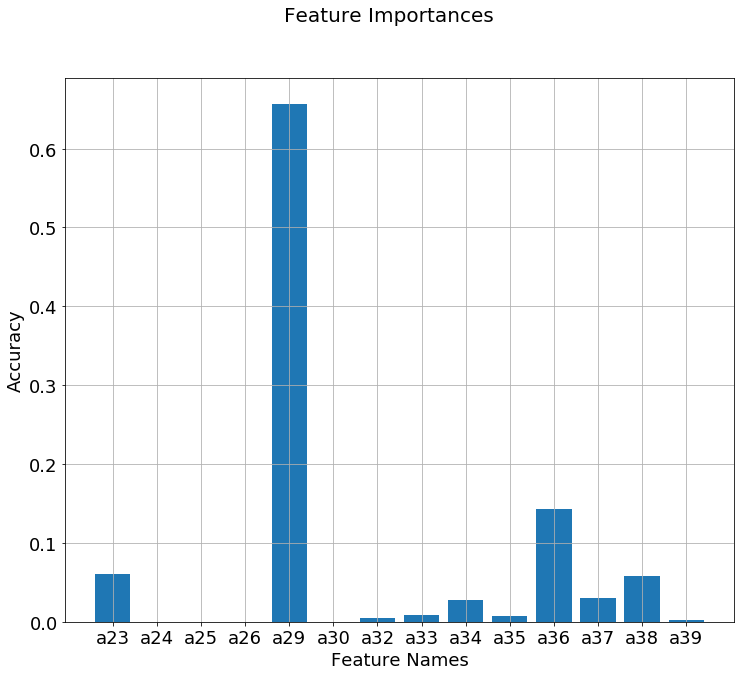

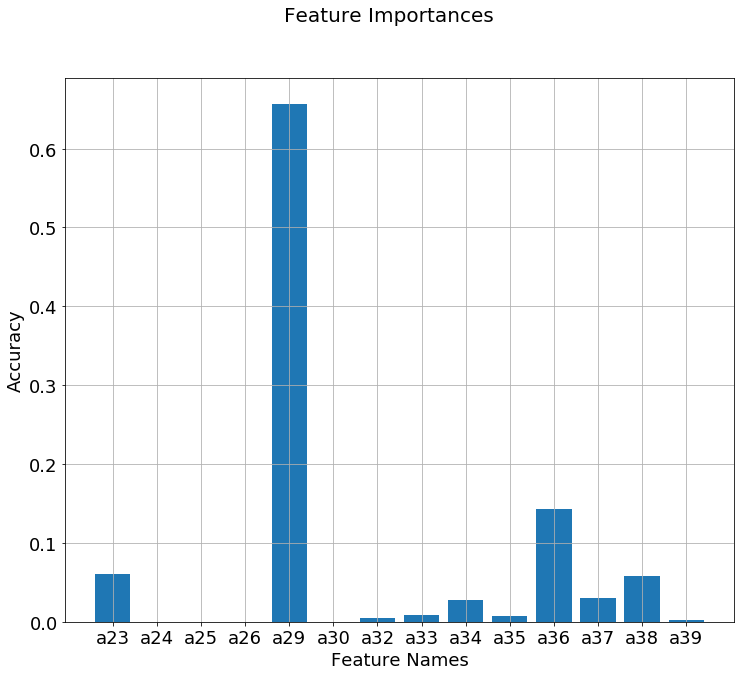

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.grid(True)
plt.suptitle("Feature Importances", fontsize=20)
plt.bar(stat_best_cols, v1_model.featureImportances)
plt.xlabel("Feature Names", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v1_feature_importances.jpeg")
plt.show()

plt.figure(figsize=(12,10))
plt.grid(True)
plt.suptitle("Feature Importances", fontsize=20)
plt.bar(stat_best_cols, v2_model.featureImportances)
plt.xlabel("Feature Names", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v2_feature_importances.jpeg")
plt.show()

**Receiver Operating Characteristic Curve of nslkdd-version1.csv and nslkdd-version2.csv**

In [34]:
from sklearn.metrics import roc_curve, auc

v1_results = v1_pred.select('probability', 'label').collect()
v2_results = v2_pred.select('probability', 'label').collect()

v1_results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in v1_results]
v2_results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in v2_results]

v1_y_test = [i[1] for i in v1_results_list]
v1_y_score = [i[0] for i in v1_results_list]
v2_y_test = [i[1] for i in v2_results_list]
v2_y_score = [i[0] for i in v2_results_list]

v1_fpr, v1_tpr, v1_ = roc_curve(v1_y_test, v1_y_score)
v2_fpr, v2_tpr, v2_ = roc_curve(v2_y_test, v2_y_score)

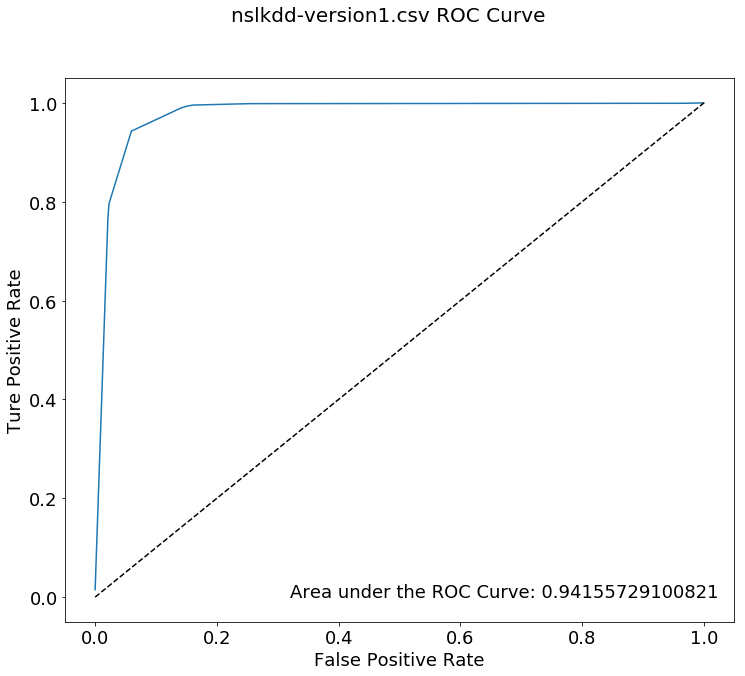

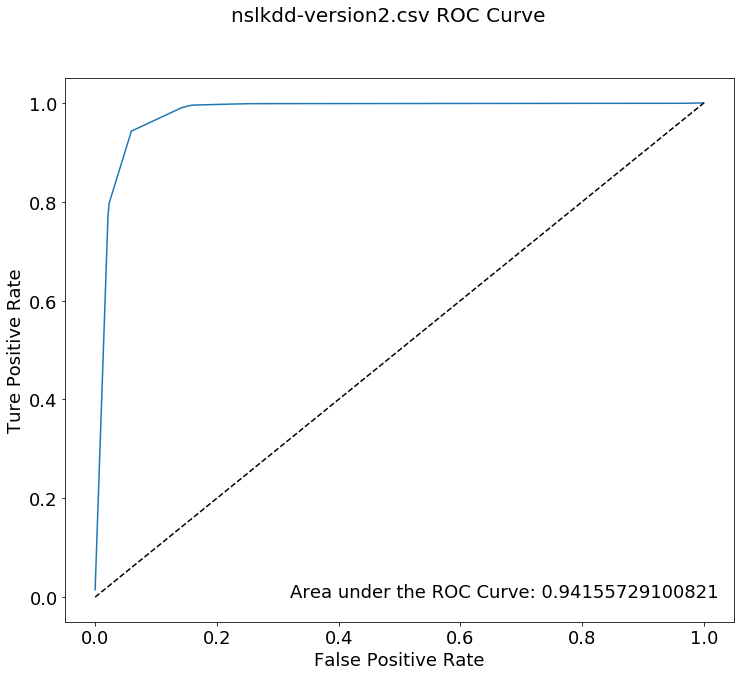

In [121]:
# nslkdd-version1.csv ROC Curve
plt.figure(figsize=(12,10)).suptitle('nslkdd-version1.csv ROC Curve', fontsize=20)
plt.plot(v1_fpr, v1_tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('Ture Positive Rate', fontsize=18)
plt.text(0.32, 0.0, "Area under the ROC Curve: %s" % v1_bce_results, size=18)
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v1_roc.jpeg")
plt.show()

# nslkdd-version2.csv ROC Curve
plt.figure(figsize=(12,10)).suptitle('nslkdd-version2.csv ROC Curve', fontsize=20)
plt.plot(v2_fpr, v2_tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('Ture Positive Rate', fontsize=18)
plt.text(0.32, 0.0, "Area under the ROC Curve: %s" % v2_bce_results, size=18)
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v2_roc.jpeg")
plt.show()

**Pie-charts of nslkdd-version1.csv and nslkdd-version2.csv to compare test-set labels with the models' predicted labels.**

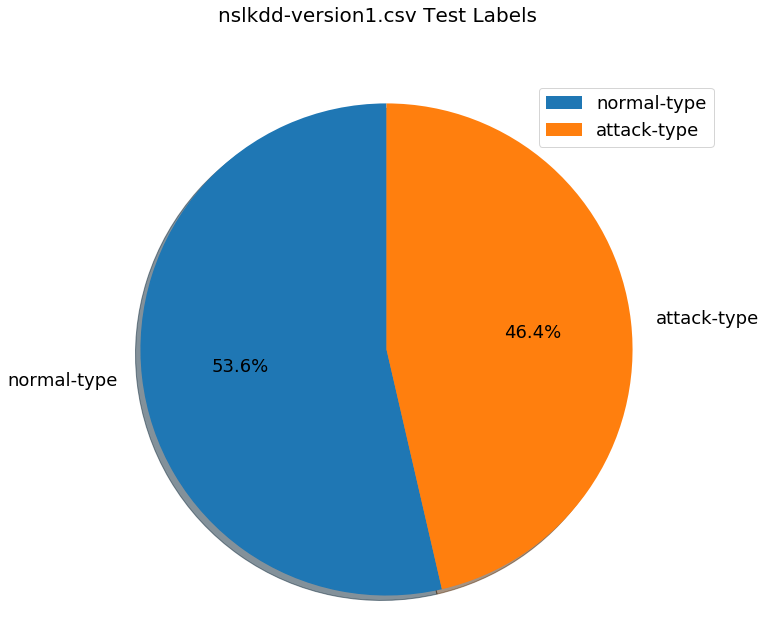

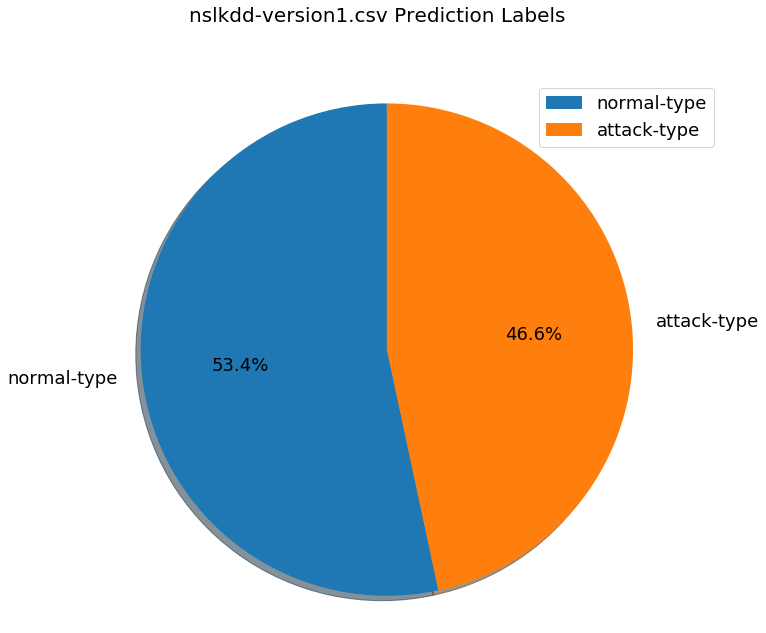

In [122]:
import matplotlib as mpl

# nslkdd-version1 Test Percentages
plt.figure(figsize=(12,10)).suptitle("nslkdd-version1.csv Test Labels", fontsize=20)
mpl.rcParams['font.size'] = 18

v1_test_label0 = (len([val[0] for val in v1_test.select('label').collect() if val[0] == 0])
                  / v1_test.count()) * 100
v1_test_label1 = (len([val[0] for val in v1_test.select('label').collect() if val[0] == 1])
                  / v1_test.count()) * 100

plt.pie([v1_test_label0, v1_test_label1], labels=['normal-type', 'attack-type'], autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.legend()
plt.axis('equal')
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v1_test_pie.jpeg")
plt.show()

# nslkdd-version1 Prediction Percentages
plt.figure(figsize=(12,10)).suptitle("nslkdd-version1.csv Prediction Labels", fontsize=20)
mpl.rcParams['font.size'] = 18

v1_pred_label0 = (len([val[0] for val in v1_pred.select('prediction').collect() if val[0] == 0])
                  / v1_pred.count()) * 100
v1_pred_label1 = (len([val[0] for val in v1_pred.select('prediction').collect() if val[0] == 1])
                  / v1_pred.count()) * 100

plt.pie([v1_pred_label0, v1_pred_label1], labels=['normal-type', 'attack-type'], autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.legend()
plt.axis('equal')
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v1_pred_pie.jpeg")
plt.show()

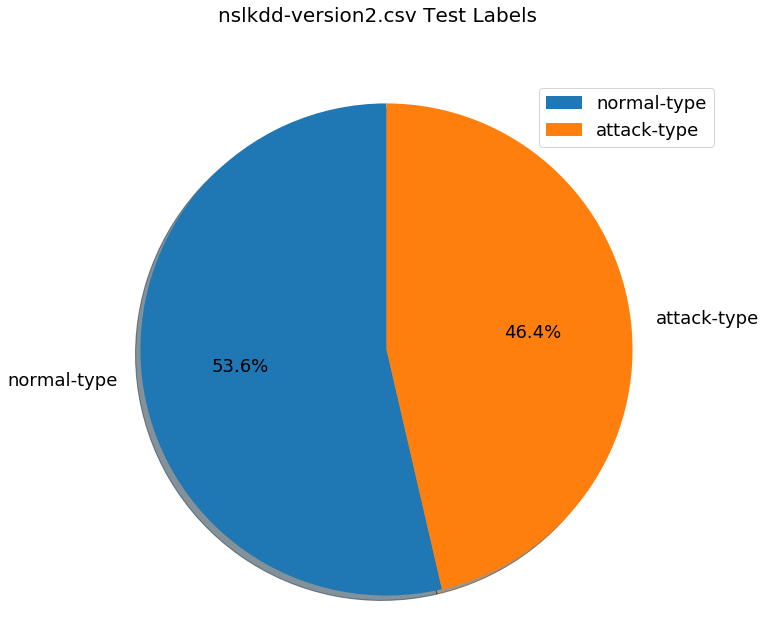

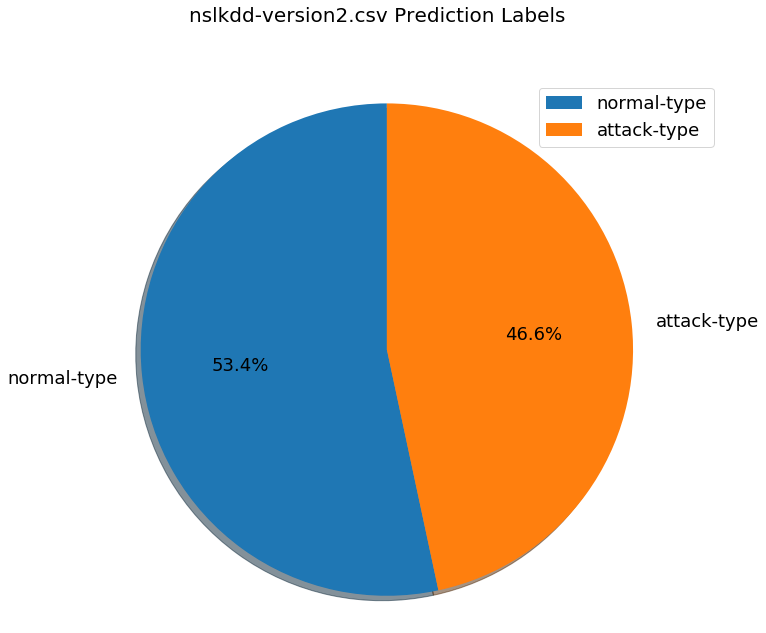

In [123]:
# nslkdd-version2 Test Percentages
plt.figure(figsize=(12,10)).suptitle("nslkdd-version2.csv Test Labels", fontsize=20)
mpl.rcParams['font.size'] = 18

v2_test_label0 = (len([val[0] for val in v2_test.select('label').collect() if val[0] == 0])
                  / v2_test.count()) * 100
v2_test_label1 = (len([val[0] for val in v2_test.select('label').collect() if val[0] == 1])
                  / v2_test.count()) * 100

plt.pie([v2_test_label0, v2_test_label1], labels=['normal-type', 'attack-type'], autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.legend()
plt.axis('equal')
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v2_test_pie.jpeg")
plt.show()

# nslkdd-version2 Prediction Percentages
plt.figure(figsize=(12,10)).suptitle("nslkdd-version2.csv Prediction Labels", fontsize=20)
mpl.rcParams['font.size'] = 18

v2_pred_label0 = (len([val[0] for val in v2_pred.select('prediction').collect() if val[0] == 0])
                  / v2_pred.count()) * 100
v2_pred_label1 = (len([val[0] for val in v2_pred.select('prediction').collect() if val[0] == 1])
                  / v2_pred.count()) * 100

plt.pie([v2_pred_label0, v2_pred_label1], labels=['normal-type', 'attack-type'], autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.legend()
plt.axis('equal')
plt.savefig("../../docs/CSC510_Assignment3_docs/report_plots/v2_pred_pie.jpeg")
plt.show()